# Chapter 3 and 4
This notebook implements the examples and figures from chapter 3 and 4.

It combines chapter 3 and 4 as the concepts from chapter 4 (policy iteration and value iteration) was used to replicate the results shown in chapter 3.

The code used to implement example 4.2 (Jack car rental) is suboptimal, messy and too much of a brute force approach. I will work on refactoring it in the future.

In [1]:
from collections import defaultdict

In [2]:
import math
import numpy as np
import copy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Agent():
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
    '''
    def __init__(self, states, actions, transition_table, discount_factor):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        # start with stochastic policy
        self.policy = {}
        for state in states:
            self.policy[state] = [(action, 1/len(self.actions[state])) for action in self.actions[state]]
        self.V = defaultdict(lambda : 0)
        self.discount_factor = discount_factor
    
    def evaluate_policy(self, threshold, verbose=False):
        while True:
            delta = 0
            oldV = copy.deepcopy(self.V)
            for state in self.states:
                v = self.V[state]
                newV = 0
                for action, prob in self.policy[state]:
                    for transition, next_state, reward in self.transition_table[(state, action)]:
                        newV += prob * transition * (reward + self.discount_factor * oldV[next_state])
                self.V[state] = newV
                delta = max(delta, abs(v - self.V[state]))
            if verbose:
                print(self.V)
            if delta < threshold:
                break
                
    def improve_policy(self):
        did_change = False
        for state in self.states:
            best_action = None
            best_value = -1000
            for action in self.actions[state]:
                action_value = 0
                for transition, next_state, reward in self.transition_table[(state, action)]:
                    action_value += transition * (reward + self.discount_factor * self.V[next_state])
                    if action_value > best_value:
                        best_action = action
                        best_value = action_value
            newPolicy = [(action, 1) if action == best_action else (action, 0) for action in self.actions[state]]
            if not all([na == oa and nv == ov for (na, nv), (oa, ov) in zip(newPolicy, self.policy[state])]):
                did_change = True
            self.policy[state] = newPolicy
        return did_change
            
                
    def iterate_policy(self):
        did_change = True
        while did_change:
            self.evaluate_policy(1e-10)
            did_change = self.improve_policy()
        

## Chapter 3, gridworld

In [8]:
# create states for gridworld. We number the states sequentially as shown
np.reshape(range(25), newshape=(5,5))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [9]:
# state A will be 1, A' will be 21
# state B will be 3, B' will be 13

In [171]:
grid_states = range(25)
grid_actions = {i: ['u', 'd', 'l', 'r'] for i in grid_states}
grid_transition_table = {}
for state in grid_states:
    for action in grid_actions[state]:
        reward = 0
        if action == 'u':
            if state < 5:
                # first row
                next_state = state
                reward = -1
            else:
                next_state = state - 5
        elif action == 'd':
            if state > 19:
                # last row
                next_state = state
                reward = -1
            else:
                next_state = state + 5
        elif action == 'r':
            if state % 5 == 4:
                # right most column
                next_state = state
                reward = -1
            else:
                next_state = state + 1
        elif action == 'l':
            if state % 5 == 0:
                # left most column
                next_state = state
                reward = -1
            else:
                next_state = state - 1
        if state == 1:
            # state A, overwrite
            next_state = 21
            reward = 10
        elif state == 3:
            next_state = 13
            reward = 5
        # regardless, prob of transition is 1
        prob = 1
        grid_transition_table[(state, action)] = [(prob, next_state, reward)] # it needs to be a list, in this case, there is only one transition

In [172]:
agent = Agent(grid_states, grid_actions, grid_transition_table, 0.9)

In [173]:
agent.evaluate_policy(1e-20, verbose=False)

In [174]:
v = [0] * 25
for i, value in agent.V.items():
    v[i] = value
np.reshape(v, newshape=(5,5))

array([[ 3.30899634,  8.78929186,  4.42761918,  5.32236759,  1.49217876],
       [ 1.52158807,  2.99231786,  2.25013995,  1.9075717 ,  0.54740271],
       [ 0.05082249,  0.73817059,  0.67311326,  0.35818621, -0.40314114],
       [-0.9735923 , -0.43549543, -0.35488227, -0.58560509, -1.18307508],
       [-1.85770055, -1.34523126, -1.22926726, -1.42291815, -1.97517905]])

In [175]:
agent.iterate_policy()

In [176]:
v = [0] * 25
for i, value in agent.V.items():
    v[i] = round(value, 1)
np.reshape(v, newshape=(5,5))

array([[ 22. ,  24.4,  22. ,  19.4,  17.5],
       [ 19.8,  22. ,  19.8,  17.8,  16. ],
       [ 17.8,  19.8,  17.8,  16. ,  14.4],
       [ 16. ,  17.8,  16. ,  14.4,  13. ],
       [ 14.4,  16. ,  14.4,  13. ,  11.7]])

In [153]:
agent.policy

{0: [('u', 0), ('d', 0), ('l', 0), ('r', 1)],
 1: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 2: [('u', 0), ('d', 0), ('l', 1), ('r', 0)],
 3: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 4: [('u', 0), ('d', 0), ('l', 1), ('r', 0)],
 5: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 6: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 7: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 8: [('u', 0), ('d', 0), ('l', 1), ('r', 0)],
 9: [('u', 0), ('d', 0), ('l', 1), ('r', 0)],
 10: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 11: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 12: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 13: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 14: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 15: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 16: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 17: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 18: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 19: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 20: [('u', 1), ('d', 0), ('l', 0), ('r', 0)],
 21: [('u', 1), ('d', 0

# Chapter 4, example 4.1
Gridworld 2

I named the variables with a suffix 4 to indicate that it is the gridworld from chapter 4

In [177]:
grid4_states = range(16)
grid4_actions = {i: ['u', 'd', 'l', 'r'] for i in grid4_states}
grid4_transition_table = {}
for state in grid4_states:
    for action in grid4_actions[state]:
        reward = -1
        if action == 'u':
            if state < 4:
                # first row
                next_state = state
                reward = -1
            else:
                next_state = state - 4
        elif action == 'd':
            if state > 11:
                # last row
                next_state = state
                reward = -1
            else:
                next_state = state + 4
        elif action == 'r':
            if state % 4 == 3:
                # right most column
                next_state = state
                reward = -1
            else:
                next_state = state + 1
        elif action == 'l':
            if state % 4 == 0:
                # left most column
                next_state = state
                reward = -1
            else:
                next_state = state - 1
        if state == 0 or state == 15:
            reward = 0
            next_state = state
        # regardless, prob of transition is 1
        prob = 1
        grid4_transition_table[(state, action)] = [(prob, next_state, reward)] # it needs to be a list, in this case, there is only one transition

In [182]:
agent2 = Agent(grid4_states, grid4_actions, grid4_transition_table, 1)

In [186]:
agent2.evaluate_policy(1e-10)

In [187]:
v = [0] * 16
for i, value in agent2.V.items():
    v[i] = round(value, 1)
np.reshape(v, newshape=(4,4))

array([[  0., -14., -20., -22.],
       [-14., -18., -20., -20.],
       [-20., -20., -18., -14.],
       [-22., -20., -14.,   0.]])

In [188]:
agent2.iterate_policy()

In [190]:
v = [0] * 16
for i, value in agent2.V.items():
    v[i] = round(value, 1)
np.reshape(v, newshape=(4,4))

array([[ 0., -1., -2., -3.],
       [-1., -2., -3., -2.],
       [-2., -3., -2., -1.],
       [-3., -2., -1.,  0.]])

## Chapter 4, Jack car rental, example 4.2

This code is suboptimal, I will refactor it in the future.

In [5]:
from scipy import stats

In [51]:
# we need to first create the state table, action tables and transition table
rental_states = [(loc1, loc2) for loc1 in range(21) for loc2 in range(21)]
rental_actions = {(loc1, loc2): list(range(max(-5, -1*loc2), min(5, loc1) + 1)) for loc1, loc2 in rental_states}
rental_transition = {}
lookup = {}
for state in rental_states:
    loc1, loc2 = state
    for action in rental_actions[state]:
        # we need to account for cars returns
        # then account for car rented out
        # and cost of car movement for computing rewards
        next_states_and_rewards = []
        next_states_and_rewards_without_action = []
        # after action, what are the vehicles at each loc
        newloc1 = loc1 - action
        newloc2 = loc2 + action
        if (newloc1, newloc2) in lookup:
            rental_transition[(state, action)] = [(prob, ns, reward+abs(action)*-2) for prob, ns, reward in lookup[(newloc1, newloc2)]]
        else:
            for rent1 in range(0, newloc1 + 1):
                prob = 1
                newloc1 -= rent1
                if newloc1 == 0:
                    prob1 = prob* (1- stats.poisson.cdf(rent1-1, 3))
                    # anything more than rental number leads to 0 too
                else:
                    prob1 = prob* stats.poisson.pmf(rent1, 3)
                for rent2 in range(0, newloc2 + 1):
                    newloc2 -= rent2
                    if newloc2 == 0:
                        prob2 = prob1* (1-stats.poisson.cdf(rent2-1, 4))
                    else:
                        prob2 = prob1* stats.poisson.pmf(rent2, 4)
                    for return1 in range(0, 20-newloc1 + 1):
                        newloc1 += return1
                        if newloc1 == 20:
                            prob3 = prob2* (1-stats.poisson.cdf(return1-1, 3))
                        else:
                            prob3 = prob2* stats.poisson.pmf(return1, 3)
                        if prob3 < 1e-6:
                            newloc1 -= return1
                            break
                        for return2 in range(0, 20-newloc2 + 1):
                            newloc2 += return2
                            if newloc2 == 20:
                                prob4 = prob3* (1-stats.poisson.cdf(return2-1, 2))
                            else:
                                prob4 = prob3* stats.poisson.pmf(return2, 2)
                            if prob4 < 1e-8:
                                newloc2 -= return2
                                break
                            # now compute reward
                            reward_without_action = 10 * (rent1 + rent2)
                            reward = -2 * abs(action) + reward_without_action
                            
                            # now store it
                            next_states_and_rewards.append((prob4, (newloc1, newloc2), reward))
                            next_states_and_rewards_without_action.append((prob4, (newloc1, newloc2), reward_without_action))
                            # reset newloc
                            newloc2 -= return2
                        newloc1 -= return1
                    newloc2 += rent2
                newloc1 += rent1
            rental_transition[(state, action)] = next_states_and_rewards
            lookup[(newloc1, newloc2)] = next_states_and_rewards_without_action

In [56]:
agent_jack = Agent(rental_states, rental_actions, rental_transition, 0.9)

In [57]:
agent_jack.policy = {state: [(action, 1)  if action == 0 else (action, 0) for action, prob in actions] for state, actions in agent_jack.policy.items()}

In [19]:
def extract_action(policy):
    for action, prob in policy:
        if prob == 1:
            return action

In [28]:
def plot_policy(policy):
    X, Y = np.meshgrid(range(0, 21, 1), range(0, 21, 1))
    zs = np.array([extract_action(policy[(y,x)]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    plt.contourf(X,Y, Z)
    plt.colorbar()

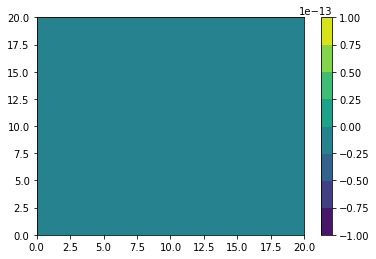

In [59]:
plot_policy(agent_jack.policy)

In [60]:
agent_jack.evaluate_policy(1e-1)
agent_jack.improve_policy()

True

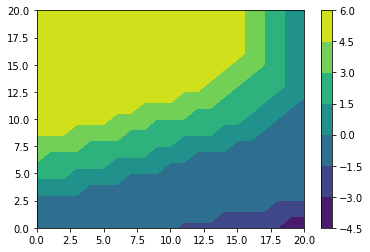

In [61]:
plot_policy(agent_jack.policy)

In [62]:
agent_jack.evaluate_policy(1e-1)
agent_jack.improve_policy()

True

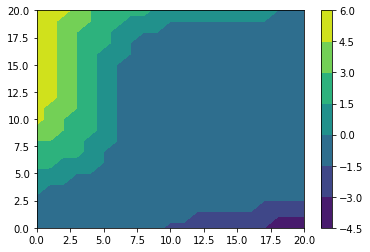

In [63]:
plot_policy(agent_jack.policy)

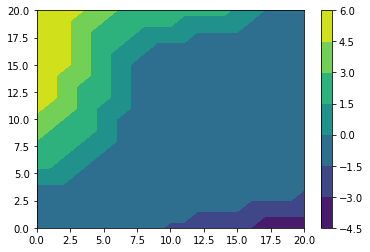

In [64]:
# 3
agent_jack.evaluate_policy(1e-1)
agent_jack.improve_policy()
plot_policy(agent_jack.policy)

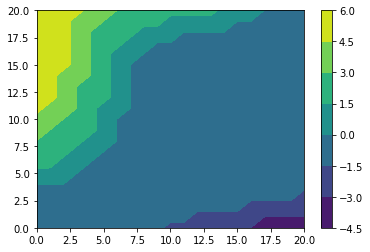

In [65]:
# 4
agent_jack.evaluate_policy(1e-1)
agent_jack.improve_policy()
plot_policy(agent_jack.policy)

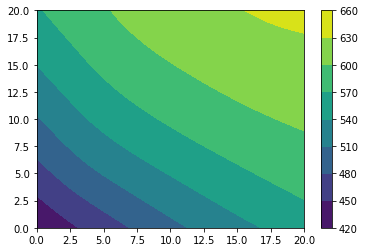

In [66]:
X, Y = np.meshgrid(range(21), range(21))
zs = np.array([agent_jack.V[(x,y)] for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
plt.contourf(X,Y, Z)
plt.colorbar()

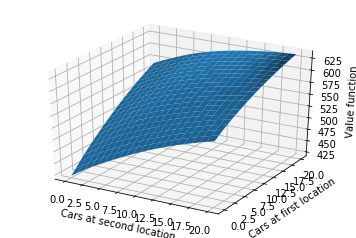

In [70]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z)

ax.set_xlabel('Cars at second location') # flipped
ax.set_ylabel('Cars at first location')
ax.set_zlabel('Value function')

plt.show()

In [8]:
import pickle

In [58]:
with open('rental_transition_3.pkl', 'wb') as f: # named _3 due to it being my third attempt
    pickle.dump(rental_transition, f)

## Chapter 4, exercise 4.4, modified Jack car rental

In [73]:
rental_transitionv2 = {}
lookup = {}

def cost_of_action(action):
    if action >= 0:
        return action * -2
    else:
        return (-1*action - 1) * -2

for state in rental_states:
    loc1, loc2 = state
    for action in rental_actions[state]:
        # we need to account for cars returns
        # then account for car rented out
        # and cost of car movement for computing rewards
        next_states_and_rewards = []
        next_states_and_rewards_without_action = []
        # after action, what are the vehicles at each loc
        newloc1 = loc1 - action
        newloc2 = loc2 + action
        if (newloc1, newloc2) in lookup:
            rental_transitionv2[(state, action)] = [(prob, ns, reward+cost_of_action(action)) for prob, ns, reward in lookup[(newloc1, newloc2)]]
        else:
            cost_of_storage = int(newloc1 > 10) * 4 + int(newloc2 > 10) * 4
            # cost of storage takes place before the renting and returning during the day time but after action
            for rent1 in range(0, newloc1 + 1):
                prob = 1
                newloc1 -= rent1
                if newloc1 == 0:
                    prob1 = prob* (1- stats.poisson.cdf(rent1-1, 3))
                    # anything more than rental number leads to 0 too
                else:
                    prob1 = prob* stats.poisson.pmf(rent1, 3)
                for rent2 in range(0, newloc2 + 1):
                    newloc2 -= rent2
                    if newloc2 == 0:
                        prob2 = prob1* (1-stats.poisson.cdf(rent2-1, 4))
                    else:
                        prob2 = prob1* stats.poisson.pmf(rent2, 4)
                    for return1 in range(0, 20-newloc1 + 1):
                        newloc1 += return1
                        if newloc1 == 20:
                            prob3 = prob2* (1-stats.poisson.cdf(return1-1, 3))
                        else:
                            prob3 = prob2* stats.poisson.pmf(return1, 3)
                        if prob3 < 1e-6:
                            newloc1 -= return1
                            break
                        for return2 in range(0, 20-newloc2 + 1):
                            newloc2 += return2
                            if newloc2 == 20:
                                prob4 = prob3* (1-stats.poisson.cdf(return2-1, 2))
                            else:
                                prob4 = prob3* stats.poisson.pmf(return2, 2)
                            if prob4 < 1e-8:
                                newloc2 -= return2
                                break
                            # now compute reward
                            reward_without_action = 10 * (rent1 + rent2) + cost_of_storage
                            reward = cost_of_action(action) + reward_without_action
                            
                            # now store it
                            next_states_and_rewards.append((prob4, (newloc1, newloc2), reward))
                            next_states_and_rewards_without_action.append((prob4, (newloc1, newloc2), reward_without_action))
                            # reset newloc
                            newloc2 -= return2
                        newloc1 -= return1
                    newloc2 += rent2
                newloc1 += rent1
            rental_transitionv2[(state, action)] = next_states_and_rewards
            lookup[(newloc1, newloc2)] = next_states_and_rewards_without_action

In [74]:
with open('rental_transitionv2.pkl', 'wb') as f:
    pickle.dump(rental_transitionv2, f)

In [76]:
agent_jack_v2 = Agent(rental_states, rental_actions, rental_transitionv2, 0.9)
agent_jack_v2.policy = {state: [(action, 1)  if action == 0 else (action, 0) for action, prob in actions] for state, actions in agent_jack_v2.policy.items()}

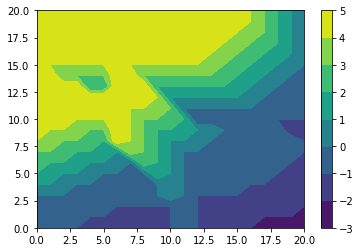

In [77]:
# 1
agent_jack_v2.evaluate_policy(1e-1)
agent_jack_v2.improve_policy()
plot_policy(agent_jack_v2.policy)

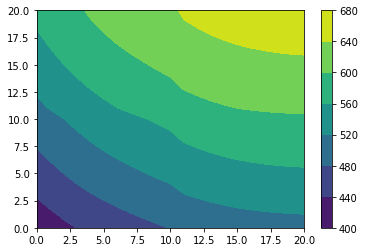

In [78]:
X, Y = np.meshgrid(range(21), range(21))
zs = np.array([agent_jack_v2.V[(x,y)] for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
plt.contourf(X,Y, Z)
plt.colorbar()

In [79]:
agent_jack_v2.iterate_policy()

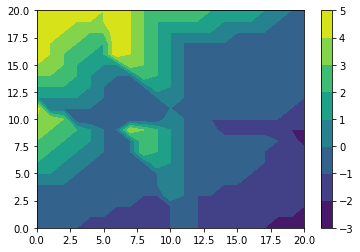

In [80]:
plot_policy(agent_jack_v2.policy)

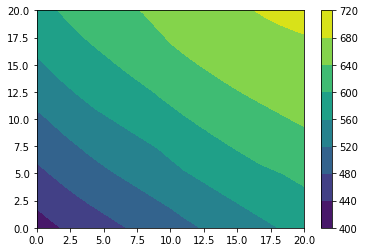

In [83]:
X, Y = np.meshgrid(range(21), range(21))
zs = np.array([agent_jack_v2.V[(x,y)] for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
plt.contourf(X,Y, Z)
plt.colorbar()

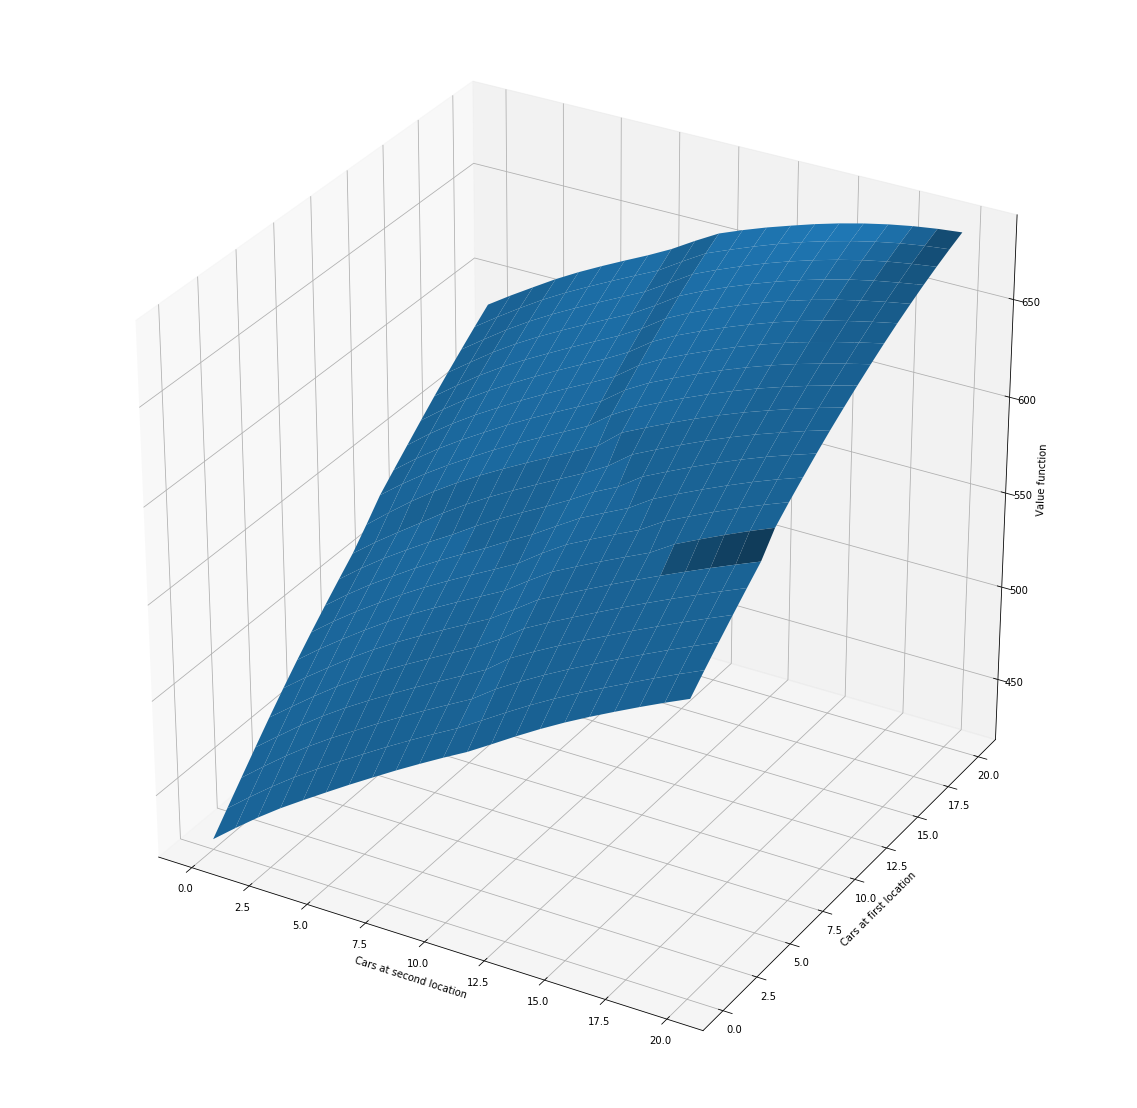

In [97]:
from mpl_toolkits.mplot3d import Axes3D  
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z)

ax.set_xlabel('Cars at second location') # flipped
ax.set_ylabel('Cars at first location')
ax.set_zlabel('Value function')

plt.show()

# the non linearity is really hard to see

## Chapter 4, exercise 4.6
Q-value policy iteration

In [117]:
class QAgent():
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
    '''
    def __init__(self, states, actions, transition_table, discount_factor, stochastic=True, init_action=None):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        # start with stochastic policy
        self.policy = {}
        if (not stochastic) and (not init_action == None):
            for state in states:
                self.policy[state] = [(action, 1) if action == init_action else (action, 0) 
                                      for action in self.actions[state]]
        else:
            for state in states:
                self.policy[state] = [(action, 1/len(self.actions[state])) for action in self.actions[state]]
        self.Q = defaultdict(lambda : 0) # key is a tuple of (state, action)
        self.discount_factor = discount_factor
    
    def evaluate_policy(self, threshold, verbose=False):
        while True:
            delta = 0
            oldQ = copy.deepcopy(self.Q)
            for state in self.states:
                for action in self.actions[state]:
                    q = self.Q[(state, action)]
                    newQ = 0
                    for transition, next_state, reward in self.transition_table[(state, action)]:
                        for next_action, prob in self.policy[next_state]:
                            newQ += transition * prob * (reward + self.discount_factor * oldQ[next_state, next_action])
                    self.Q[state, action] = newQ
                    delta = max(delta, abs(q - self.Q[state, action]))
            if verbose:
                print(self.Q)
            if delta < threshold:
                break
                
    def improve_policy(self):
        did_change = False
        for state in self.states:
            best_action = None
            best_value = -1000
            for action in self.actions[state]:
                if self.Q[state, action] > best_value:
                    best_action = action
                    best_value = self.Q[state, action]
            newPolicy = [(action, 1) if action == best_action else (action, 0) for action in self.actions[state]]
            if not all([na == oa and nv == ov for (na, nv), (oa, ov) in zip(newPolicy, self.policy[state])]):
                did_change = True
            self.policy[state] = newPolicy
        return did_change
            
                
    def iterate_policy(self):
        did_change = True
        while did_change:
            self.evaluate_policy(5e-1)
            did_change = self.improve_policy()
        

In [118]:
qagent_jack = QAgent(rental_states, rental_actions, rental_transition, 0.9, stochastic=False, init_action=0)

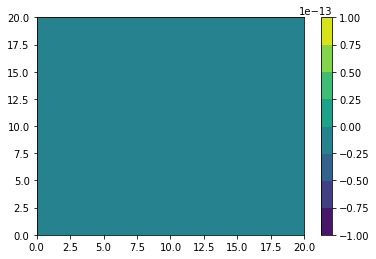

In [119]:
plot_policy(qagent_jack.policy)

In [120]:
qagent_jack.evaluate_policy(threshold=5e-1)

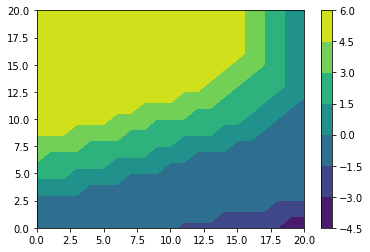

In [121]:
qagent_jack.improve_policy()
plot_policy(qagent_jack.policy)

In [122]:
qagent_jack.iterate_policy()

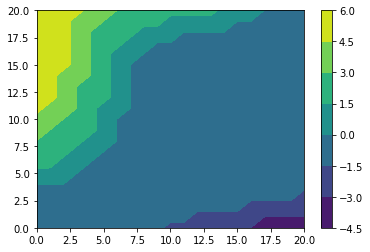

In [123]:
plot_policy(qagent_jack.policy)

## Chapter 4, example 4.3, Gambler's Problem

I will first create a value iteration agent called VIAgent

In [279]:
# helper from http://code.activestate.com/recipes/578114-round-number-to-specified-number-of-significant-di/
def round_sigfigs(num, sig_figs):
    """Round to specified number of sigfigs.

    >>> round_sigfigs(0, sig_figs=4)
    0
    >>> int(round_sigfigs(12345, sig_figs=2))
    12000
    >>> int(round_sigfigs(-12345, sig_figs=2))
    -12000
    >>> int(round_sigfigs(1, sig_figs=2))
    1
    >>> '{0:.3}'.format(round_sigfigs(3.1415, sig_figs=2))
    '3.1'
    >>> '{0:.3}'.format(round_sigfigs(-3.1415, sig_figs=2))
    '-3.1'
    >>> '{0:.5}'.format(round_sigfigs(0.00098765, sig_figs=2))
    '0.00099'
    >>> '{0:.6}'.format(round_sigfigs(0.00098765, sig_figs=3))
    '0.000988'
    """
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0

In [505]:
class VIAgent:
    '''
    Params:
        actions: a dictionary mapping states to allowed actions
        states: a list of states
        transition_table: a dictionary mapping a tuple of (state, action) to a list of (p(s', r), s', r)
        init_V: a dictionary mapping states to their initial value
    '''
    def __init__(self, states, actions, transition_table, discount_factor, init_V=None):
        self.states = states
        self.actions = actions
        self.transition_table = transition_table
        self.discount_factor = discount_factor
        if init_V is not None:
            self.V = copy.deepcopy(init_V)
        else:
            self.V = {state: 0 for state in self.states}
        # no need for policy
        
    def value_iteration(self, threshold=1e-5, iterations=None):
        step = 0
        while True:
            delta = 0
            for state in self.states:
                v = self.V[state]
                maxV = -1000
                for action in self.actions[state]:
                    value = 0
                    for transition, next_state, reward in self.transition_table[state, action]:
                        value += transition * (reward + self.discount_factor * self.V[next_state]) # uses latest estimate of V(s')
                    if value > maxV:
                        maxV = value
                self.V[state] = maxV
                delta = max(delta, abs(v-self.V[state]))
            step += 1
            if iterations is not None and step >= iterations:
                break
            if delta < threshold:
                break
        
    def get_policy(self, sigfig=5):
        policy = {} # maps state to a list of (action, prob). 
        # Value iteration is deterministic, but this is for compatbility
        for state in self.states:
            best_action = None
            best_value = -10000
            for action in self.actions[state]:
                v = 0
                for transition, next_state, reward in self.transition_table[state, action]:
                    v += transition * (reward + self.discount_factor * self.V[next_state])
                if round_sigfigs(v, sigfig) > round_sigfigs(best_value, sigfig):
                    best_action = action
                    best_value = v
            policy[state] = [(best_action, 1)]
        return policy

In [369]:
def get_gambler_prob(ph=0.4):
    states = list(range(1, 100))
    actions = {state: list(range(1, min(state, 100-state) + 1)) for state in states}
    # note that the textbook states that 0 is an allowed action. However, I can't replicate the result if I allowed it
    transition_table = {}
    for state in states:
        for action in actions[state]:
            transition_table[(state, action)] = [(ph, state + action, 0), (1-ph, state-action, 0)] # 0 reward all the time
    init_V = {state: 0 for state in states}
    init_V[0] = 0
    init_V[100] = 1
    return states, actions, transition_table, init_V

In [455]:
gambler_0_4_states, gambler_0_4_actions, gambler_0_4_transition, gambler_0_4_init_V = get_gambler_prob(0.4)

In [456]:
viagent_gambler = VIAgent(gambler_0_4_states, gambler_0_4_actions, gambler_0_4_transition, 1, init_V=gambler_0_4_init_V)

In [457]:
viagent_gambler.value_iteration(iterations=1)
sweep1 = copy.deepcopy(viagent_gambler.V)
viagent_gambler.value_iteration(iterations=1)
sweep2 = copy.deepcopy(viagent_gambler.V)
viagent_gambler.value_iteration(iterations=1)
sweep3 = copy.deepcopy(viagent_gambler.V)
viagent_gambler.value_iteration(iterations=29)
sweep32 = copy.deepcopy(viagent_gambler.V)
viagent_gambler.value_iteration()
final_v = viagent_gambler.V

([<matplotlib.axis.XTick at 0x293630be0>,
 <a list of 5 Text xticklabel objects>)

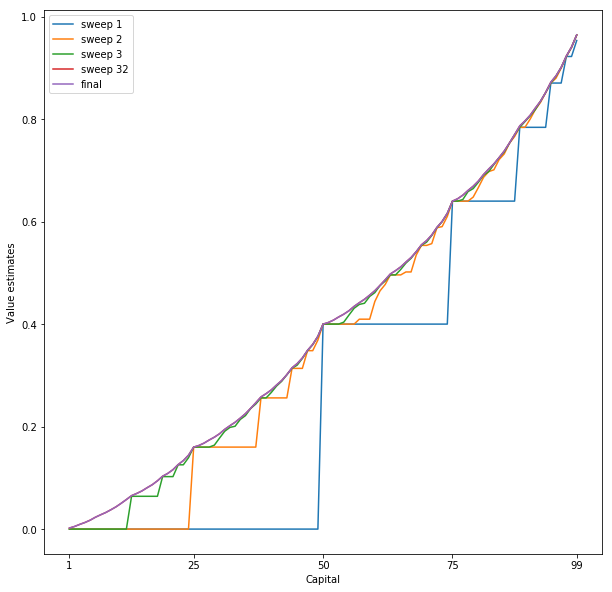

In [458]:
plt.figure(figsize=(10,10))
plt.plot(range(1, 100), [sweep1[i] for i in range(1,100)], label="sweep 1")
plt.plot(range(1, 100), [sweep2[i] for i in range(1,100)], label="sweep 2")
plt.plot(range(1, 100), [sweep3[i] for i in range(1,100)], label="sweep 3")
plt.plot(range(1, 100), [sweep32[i] for i in range(1,100)], label="sweep 32")
plt.plot(range(1, 100), [final_v[i] for i in range(1,100)], label="final")
plt.legend()
plt.ylabel("Value estimates")
plt.xlabel("Capital")
plt.xticks([1,25,50,75,99])

Text(0.5,0,'Capital')

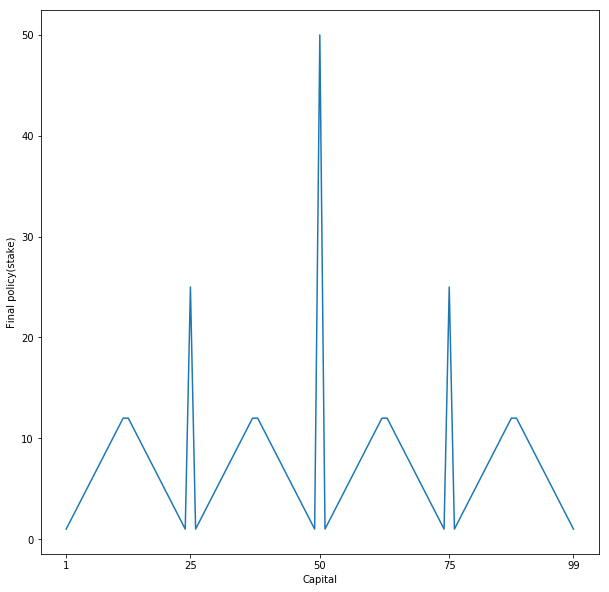

In [459]:
policy = viagent_gambler.get_policy(sigfig=5)
plt.figure(figsize=(10,10))
plt.plot(range(1,100), [policy[i][0][0] for i in range(1,100)])
plt.xticks([1,25,50,75,99])
plt.ylabel("Final policy(stake)")
plt.xlabel("Capital")

### Exercise 4.8, ph = 0.25

In [465]:
gambler_0_25_states, gambler_0_25_actions, gambler_0_25_transition, gambler_0_25_init_V = get_gambler_prob(0.25)

In [466]:
viagent_gambler_0_25 = VIAgent(gambler_0_25_states, gambler_0_25_actions, gambler_0_25_transition, 1, init_V=gambler_0_25_init_V)

In [467]:
viagent_gambler_0_25.value_iteration(threshold=1e-30)
final_v_0_25 = viagent_gambler_0_25.V

([<matplotlib.axis.XTick at 0x2945659e8>,
 <a list of 5 Text xticklabel objects>)

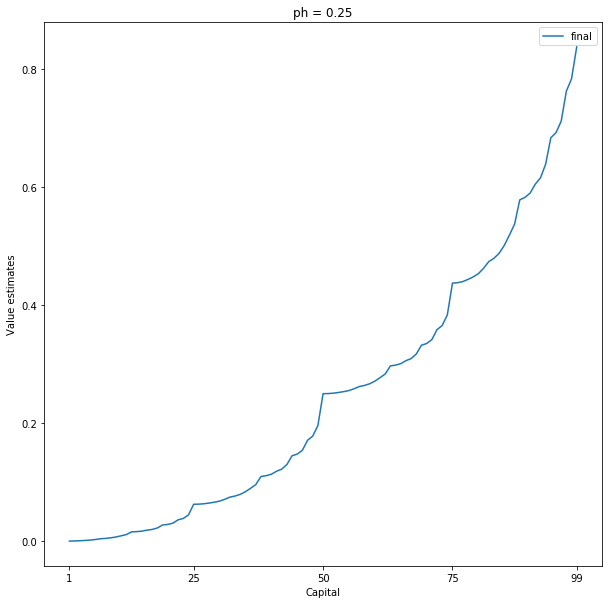

In [468]:
plt.figure(figsize=(10,10))
plt.plot(range(1, 100), [final_v_0_25[i] for i in range(1,100)], label="final")
plt.legend()
plt.title("ph = 0.25")
plt.ylabel("Value estimates")
plt.xlabel("Capital")
plt.xticks([1,25,50,75,99])

Text(0.5,0,'Capital')

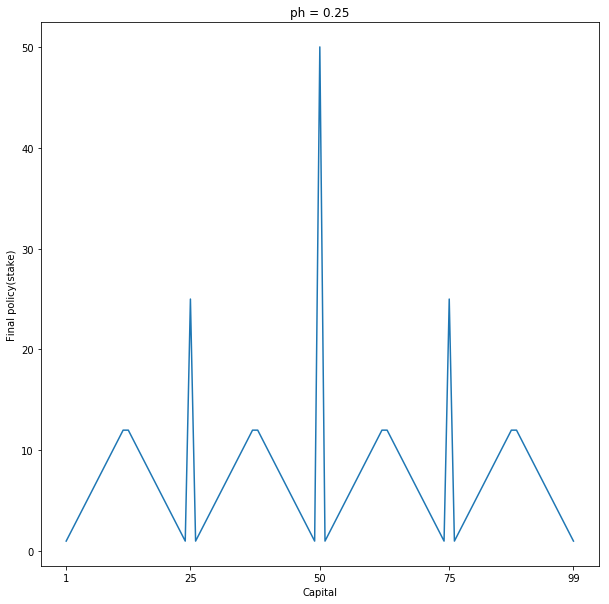

In [469]:
policy = viagent_gambler_0_25.get_policy(sigfig=5)
plt.figure(figsize=(10,10))
plt.plot(range(1,100), [policy[i][0][0] for i in range(1,100)])
plt.xticks([1,25,50,75,99])
plt.title("ph = 0.25")
plt.ylabel("Final policy(stake)")
plt.xlabel("Capital")

# I don't think this policy makes sense

### Exercise 4.8, ph = 0.55

In [479]:
gambler_0_55_states, gambler_0_55_actions, gambler_0_55_transition, gambler_0_55_init_V = get_gambler_prob(0.55)

In [480]:
viagent_gambler_0_55 = VIAgent(gambler_0_55_states, gambler_0_55_actions, gambler_0_55_transition, 1, init_V=gambler_0_55_init_V)

In [481]:
viagent_gambler_0_55.value_iteration(threshold=1e-10)
final_v_0_55 = viagent_gambler_0_55.V

([<matplotlib.axis.XTick at 0x2997d26a0>,
 <a list of 5 Text xticklabel objects>)

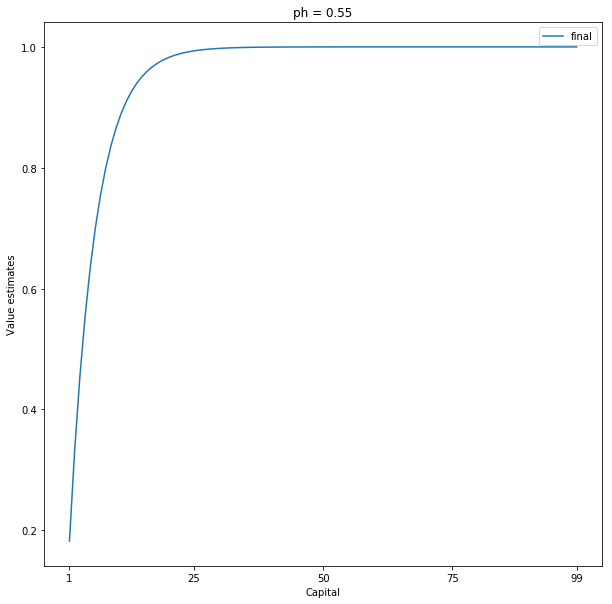

In [482]:
plt.figure(figsize=(10,10))
plt.plot(range(1, 100), [final_v_0_55[i] for i in range(1,100)], label="final")
plt.legend()
plt.title("ph = 0.55")
plt.ylabel("Value estimates")
plt.xlabel("Capital")
plt.xticks([1,25,50,75,99])

Text(0.5,0,'Capital')

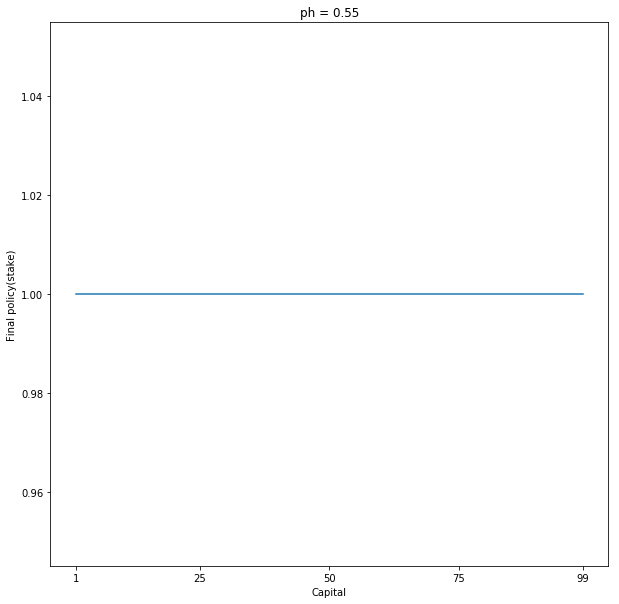

In [483]:
policy = viagent_gambler_0_55.get_policy(sigfig=20)
plt.figure(figsize=(10,10))
plt.plot(range(1,100), [policy[i][0][0] for i in range(1,100)])
plt.xticks([1,25,50,75,99])
plt.title("ph = 0.55")
plt.ylabel("Final policy(stake)")
plt.xlabel("Capital")

# I don't think this policy makes sense

### Exercise 4.8, ph = 0.1

In [530]:
gambler_0_1_states, gambler_0_1_actions, gambler_0_1_transition, gambler_0_1_init_V = get_gambler_prob(0.1)

In [531]:
viagent_gambler_0_1 = VIAgent(gambler_0_1_states, gambler_0_1_actions, gambler_0_1_transition, 1, init_V=gambler_0_1_init_V)

In [532]:
viagent_gambler_0_1.value_iteration(threshold=1e-50)
final_v_0_1 = viagent_gambler_0_1.V

([<matplotlib.axis.XTick at 0x29bd3ab38>,
 <a list of 5 Text xticklabel objects>)

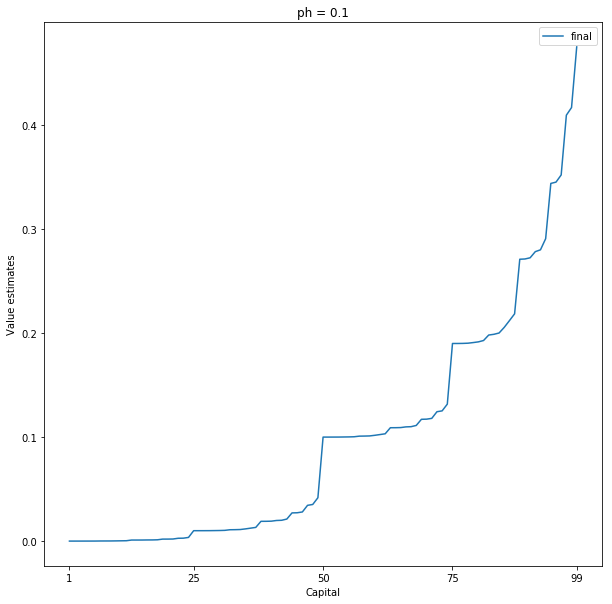

In [533]:
plt.figure(figsize=(10,10))
plt.plot(range(1, 100), [final_v_0_1[i] for i in range(1,100)], label="final")
plt.legend()
plt.title("ph = 0.1")
plt.ylabel("Value estimates")
plt.xlabel("Capital")
plt.xticks([1,25,50,75,99])

Text(0.5,0,'Capital')

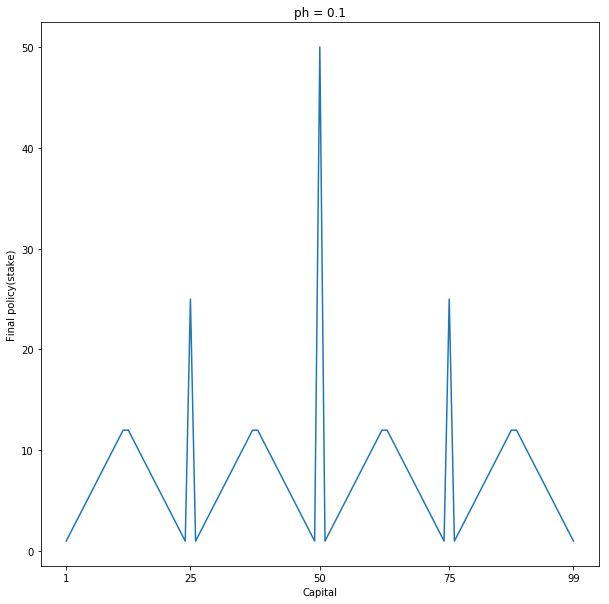

In [534]:
policy = viagent_gambler_0_1.get_policy(sigfig=6)
plt.figure(figsize=(10,10))
plt.plot(range(1,100), [policy[i][0][0] for i in range(1,100)])
plt.xticks([1,25,50,75,99])
plt.title("ph = 0.1")
plt.ylabel("Final policy(stake)")
plt.xlabel("Capital")

# I don't think this policy makes sense